In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import pandas as pd
import scipy.stats
import math
from pyfasta import Fasta
import tqdm
import seaborn as sns

In [21]:
def mergeHeraKallistoBowtieSTAR(typeof,files):
    #truth
    truth = pd.read_table(files[typeof]["truth"], delim_whitespace=True, \
       usecols=["transcript_id", "count"])
    df = truth
    df.rename(index=str, \
            columns={"transcript_id": "Name", "count": "count"}, inplace = True)
    
    #SLA soft
    sla_soft = pd.read_table(files[typeof]["SLA_soft"], delim_whitespace=True, \
                                 usecols=["Name", "NumReads"])
    sla_soft.rename(index=str, columns = {"Name": "Name", \
                                    "NumReads" : "NumReads_soft"}, inplace = True)
    df = pd.merge(df,sla_soft, how="outer", on = "Name").fillna(0.0)
    
    #SLA strict
    sla_strict = pd.read_table(files[typeof]["SLA_strict"], delim_whitespace=True, \
                                 usecols=["Name", "NumReads"])
    sla_strict.rename(index=str, columns = {"Name": "Name", \
                                    "NumReads" : "NumReads_strict"}, inplace = True)
    df = pd.merge(df, sla_strict, how="outer", on = "Name").fillna(0.0)
    
    #Bowtie2
    
    bowtie = pd.read_table(files[typeof]["bowtie"], delim_whitespace=True, \
                                 usecols=["Name", "NumReads"])
    bowtie.rename(index=str, columns = {"Name" : "Name", \
                                        "NumReads": "NumReads_BT"}, inplace = True)
    
    df = pd.merge(df,bowtie, how="outer", on = "Name").fillna(0.0)
    
    
    #star
    star = pd.read_table(files[typeof]["star"], delim_whitespace=True, \
                                 usecols=["Name", "NumReads"])
    star.rename(index=str, columns = {"Name" : "Name", \
                                        "NumReads": "NumReads_STAR"}, inplace = True)
    
    df = pd.merge(df,star, how="outer", on = "Name").fillna(0.0)
    
    #hera
    
    hera = pd.read_table(files[typeof]["hera"], delim_whitespace=True, \
                                 usecols=["#target_id", "est_counts"])
    hera["#target_id"]= hera["#target_id"].str.split(":",expand=True)[0]
    hera.rename(index=str, columns={"#target_id": "Name", \
                                           "est_counts": "NumReads_hera"}, inplace = True)
    df = pd.merge(df,hera, how="outer", on = "Name").fillna(0.0)
        
    
    
    #kallisto
    kallisto = pd.read_table(files[typeof]["kallisto"], delim_whitespace=True, \
                                     usecols=["target_id", "est_counts"])
    kallisto.rename(index=str, columns={"target_id": "Name", \
                                                "est_counts": "NumReads_KAL"}, inplace = True)
    df = pd.merge(df,kallisto, how="outer", on = "Name").fillna(0.0)
    
    return df

In [2]:
def relDiff(c1, c2, DF, cutoff=0.01, verbose=False):
    import pandas as pd
    """
    Computes the relative difference between the values
    in columns c1 and c2 of DF.
    c1 and c2 are column names and DF is a Pandas data frame.
    Values less than cutoff will be treated as 0.
    The relative difference is defined as
    d(x_i, y_i) =
        0.0 if x_i and y_i are 0
        (x_i - y_i) / (0.5 * |x_i - y_i|) otherwise
    This function returns two values.
    rd is a DataFrame where the "relDiff" column contains all
    of the computed relative differences.
    nz is a set of indexes into rd for data points where
    x_i and y_i were not *both* zero.
    """
    import numpy as np
    rd = pd.DataFrame(data = {"Name" : DF.index, "relDiff" : np.zeros(len(DF.index))*np.nan})
    rd.set_index("Name", inplace=True)
    bothZero = DF.loc[(DF[c1] <= cutoff) & (DF[c2] <= cutoff)].index
    nonZero = DF.index.difference(bothZero)
    if (verbose):
        print("Zero occurs in both columns {} times".format(len(rd.loc[bothZero])))
        print("Nonzero occurs in at least 1 column {} times".format(len(rd.loc[nonZero])))
    allRD = 1.0 * ((DF[c1] - DF[c2]) / (DF[c1] + DF[c2]).abs())
    assert(len(rd.loc[nonZero]["relDiff"]) == len(allRD[nonZero]))
    rd["relDiff"][nonZero] = allRD[nonZero]
    if len(bothZero) > 0:
        rd["relDiff"][bothZero] = 0.0
    #return rd, nonZero
    return rd.abs().mean()[0]

In [10]:
def prepareFileInfo(prefix,all_type):    
    types = all_type
    files = {}
    for t in types:
        fileinfo = {}
        fileinfo["truth"]= "/".join([prefix,t,"truth.tsv"])
        #"/home/rob/salmon/build/reads_108.truth"
    
        fileinfo["SLA_soft"] =  "/".join([prefix,t,"salmon_out","soft_filter","quant.sf"])
        fileinfo["SLA_strict"] = "/".join([prefix,t,"salmon_out","strict_filter","quant.sf"])
        
        
        fileinfo["kallisto"] = "/".join([prefix,t,"kallisto_out","abundance.tsv"])
        fileinfo["hera"] = "/".join([prefix,t,"hera_out","abundance.tsv"])
        
        fileinfo["bowtie"] = "/".join([prefix,t,"bowtie_out","quant.sf"])
        fileinfo["star"] = "/".join([prefix,t,"star_out","no_option","quant.sf"])
        
        files[t] = fileinfo
    return files

In [36]:
def getDataframe(files, all_type, mut):
    result_df = pd.DataFrame(columns=['sample',
                                      'kallisto',
                                      'hera',
                                      'Selective_Alignment_soft', 
                                      'Selective_Alignment_strict', 
                                      'STAR',
                                      'Bowtie2',
                                      'mutation_rate'
                                     ])
    
    result_df_mard = pd.DataFrame(columns=['sample',
                                      'kallisto',
                                      'hera',
                                      'Selective_Alignment_soft', 
                                      'Selective_Alignment_strict', 
                                      'STAR',
                                      'Bowtie2',
                                      'mutation_rate'
                                     ])
    
    types = all_type
    
    for i,t in enumerate(types):
        
        df = mergeHeraKallistoBowtieSTAR(t,files)
        kal=df["count"].corr(df["NumReads_KAL"],method="spearman")
        
        sla_soft=df["count"].corr(df["NumReads_soft"],method="spearman")
        sla_strict = df["count"].corr(df["NumReads_strict"],method="spearman")
        
        star = df["count"].corr(df["NumReads_STAR"],method="spearman")
        
        hera=df["count"].corr(df["NumReads_hera"],method="spearman")
        bt=df["count"].corr(df["NumReads_BT"],method="spearman")
        
        result_df.loc[i] = [t,kal,hera,sla_soft,sla_strict,star,bt,mut]
        
        kal_mard = relDiff("count","NumReads_KAL",df)
        sla_soft_mard = relDiff("count","NumReads_soft",df)
        sla_strict_mard = relDiff("count","NumReads_strict",df)
        star_mard =  relDiff("count","NumReads_STAR",df)
        hera_mard =  relDiff("count","NumReads_hera",df)
        bt_mard = relDiff("count","NumReads_BT",df)
        
        result_df_mard.loc[i] = [t,kal_mard,hera_mard,sla_soft_mard,sla_strict_mard,star_mard,bt_mard,mut]
        
    return result_df,result_df_mard,df


In [187]:
prefix = {}
prefix["all"] = "/mnt/scratch7/hirak/bleed_through_7/SRR5638585_polyreads_full/"

In [188]:
corr_dataframe = pd.DataFrame()
mard_dataframe = pd.DataFrame()
dataframes = {}
for mut_rate in range(1,6):
    files_full = prepareFileInfo(prefix["all"]+"/all_quant_mutated"+str(mut_rate),["reads_111"])
    result_full, result_dull_mard,dataframes[mut_rate] =  getDataframe(files_full,["reads_111"],mut_rate)
    corr_dataframe = corr_dataframe.append(result_full)
    mard_dataframe = mard_dataframe.append(result_dull_mard)

In [189]:
corr_dataframe

,sample,kallisto,hera,Selective_Alignment_soft,Selective_Alignment_strict,STAR,Bowtie2,mutation_rate
0,reads_111,0.905779,0.934549,0.945572,0.945404,0.941675,0.947635,1.0
0,reads_111,0.871405,0.924520,0.941596,0.941205,0.938663,0.945447,2.0
0,reads_111,0.843678,0.909997,0.935144,0.934342,0.933500,0.941775,3.0
0,reads_111,0.816621,0.880257,0.924788,0.923605,0.924915,0.936951,4.0
0,reads_111,0.792664,0.845078,0.903699,0.902655,0.908948,0.926758,5.0


In [208]:
for row in corr_dataframe.itertuples():
    print("{0:.3f} & {1:.3f} & {2:.3f} & {3:.3f} & {4:.3f}"\
          .format(row.kallisto,row.hera,row.Selective_Alignment_soft,row.STAR,row.Bowtie2))

0.906 & 0.935 & 0.946 & 0.942 & 0.948
0.871 & 0.925 & 0.942 & 0.939 & 0.945
0.844 & 0.910 & 0.935 & 0.933 & 0.942
0.817 & 0.880 & 0.925 & 0.925 & 0.937
0.793 & 0.845 & 0.904 & 0.909 & 0.927


In [209]:
for row in mard_dataframe.itertuples():
    print("{0:.3f} & {1:.3f} & {2:.3f} & {3:.3f} & {4:.3f}"\
          .format(row.kallisto,row.hera,row.Selective_Alignment_soft,row.STAR,row.Bowtie2))

0.161 & 0.116 & 0.100 & 0.104 & 0.096
0.193 & 0.132 & 0.108 & 0.109 & 0.100
0.215 & 0.172 & 0.120 & 0.115 & 0.107
0.236 & 0.231 & 0.143 & 0.127 & 0.118
0.257 & 0.291 & 0.186 & 0.150 & 0.142


In [190]:
mard_dataframe

,sample,kallisto,hera,Selective_Alignment_soft,Selective_Alignment_strict,STAR,Bowtie2,mutation_rate
0,reads_111,0.160510,0.116231,0.100465,0.100191,0.104469,0.096147,1.0
0,reads_111,0.192612,0.131911,0.107754,0.107810,0.108969,0.100140,2.0
0,reads_111,0.214762,0.171936,0.119919,0.120730,0.115173,0.106548,3.0
0,reads_111,0.236385,0.231124,0.143090,0.143977,0.127348,0.118437,4.0
0,reads_111,0.256775,0.291008,0.185630,0.186690,0.150397,0.142468,5.0


In [212]:
files_full = prepareFileInfo(prefix["all"]+"/quant_mutated1",\
                             ["reads_111","reads_99","reads_95","reads_195","reads_93"])
result_full, result_dull_mard,dataframes[1] =  getDataframe(files_full,\
                                                                   ["reads_111","reads_99","reads_95","reads_195","reads_93"],1)

In [217]:
result_full.drop(['Selective_Alignment_strict','mutation_rate'], axis=1, inplace=True)

In [218]:
result_full

,sample,kallisto,hera,Selective_Alignment_soft,STAR,Bowtie2
0,reads_111,0.905779,0.934549,0.945572,0.941675,0.947635
1,reads_99,0.906644,0.933727,0.946101,0.942524,0.948111
2,reads_95,0.906307,0.935500,0.946302,0.942346,0.948158
3,reads_195,0.905788,0.935108,0.945808,0.941894,0.947606
4,reads_93,0.906142,0.934466,0.946182,0.942213,0.947973


In [219]:
result_dull_mard.drop(['Selective_Alignment_strict','mutation_rate'], axis=1, inplace=True)

In [249]:
sns.set_style("white")
rmelt = pd.melt(result_full, id_vars=['sample'], value_vars=["kallisto","hera","Selective_Alignment_soft","STAR","Bowtie2"])

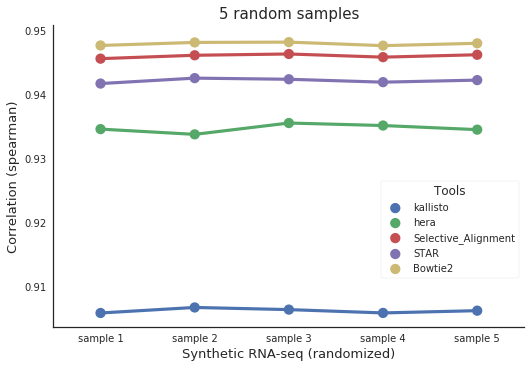

In [329]:
g = sns.factorplot(x="sample", y="value", hue='variable', data=rmelt, size=5, aspect=1.5, legend=False)

g.set_xticklabels(['sample '+str(i) for i in range(1,6)])
g.set_xlabels("Synthetic RNA-seq (randomized)",fontsize=13)
g.set_ylabels("Correlation (spearman)",fontsize=13)

handles, _ = g.ax.get_legend_handles_labels()
g.ax.legend(handles, ["kallisto","hera","Selective_Alignment","STAR","Bowtie2"],
            bbox_to_anchor=(1, .5),frameon=True)

leg = g.axes.flat[0].get_legend()
leg.set_title('Tools')
g.ax.set_title('5 random samples',fontsize = 15)

#g.ax.legend(bbox_to_anchor=(1, .5),frameon=True)

g.savefig('/mnt/scratch7/hirak/bleed_through_7/figs/standard_error.pdf', dpi=500)

In [232]:
np.arange(0.01, 0.06, 0.005)

array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055])

In [221]:
result_full.std(axis=0)

kallisto                    0.000366
hera                        0.000676
Selective_Alignment_soft    0.000298
STAR                        0.000343
Bowtie2                     0.000261
dtype: float64

In [222]:
 result_dull_mard.std(axis=0)

kallisto                    0.000444
hera                        0.000325
Selective_Alignment_soft    0.000327
STAR                        0.000414
Bowtie2                     0.000214
dtype: float64

In [143]:
def parseTimeLogString(logfile):
    with open(logfile) as fp:
        lines = fp.readlines()
        
        time_mem = lines[-2].strip() 
        time_dur = time_mem.split(" ")[2][:-7]
        mem_d = time_mem.split(" ")[5][:-13]
        
        return time_dur, mem_d

def parseTimeLog(logfile):
    with open(logfile) as fp:
        lines = fp.readlines()
        
        time_mem = lines[-2].strip()
        time_dur = time_mem.split(" ")[2][:-7]
        if time_dur.count(':') == 2:
            hour, minu, sec = map(float, time_dur.split(":"))
            time_d = hour * 3600 + minu * 60 + sec 
            #time_d = datetime.strptime(time_dur, '%H:%M:%S')
            mem_d = time_mem.split(" ")[5][:-13]
            return time_d, float(mem_d)
        else:
            #time_d = datetime.strptime(time_dur, '%M:%S.%f')
            minu, sec = map(float, time_dur.split(":"))
            time_d = minu*60 + sec
            mem_d = time_mem.split(" ")[5][:-13]
            return time_d, float(mem_d)

In [ ]:
logfiles[mut_rate]['kallisto'] = "/".join([prefix["all"], "all_quant_mutated"+str(i),"reads_111/kallisto_out/kallisto.log"])

In [167]:
from collections import defaultdict

logfiles = {}
time_df = pd.DataFrame(columns=['kallisto',
                                      'hera',
                                      'Selective_Alignment_soft', 
                                      'Selective_Alignment_strict', 
                                      'STAR',
                                      'Bowtie2',
                                      'mutation_rate'
                                     ])
    
mem_df = pd.DataFrame(columns=['kallisto',
                                      'hera',
                                      'Selective_Alignment_soft', 
                                      'Selective_Alignment_strict', 
                                      'STAR',
                                      'Bowtie2',
                                      'mutation_rate'
                                     ])


for mut_rate in range(1,6):
    logfiles[mut_rate] = {}
    
    logfiles[mut_rate]['bowtie'] = ["/".join([prefix["all"], "all_quant_mutated"+str(mut_rate),"reads_111/bowtie_out/bowtie.log"]),
                          "/".join([prefix["all"], "all_quant_mutated"+str(mut_rate),"reads_111/bowtie_out/salmon.log"])]
    logfiles[mut_rate]['star'] = ["/".join([prefix["all"], "all_quant_mutated"+str(mut_rate),"reads_111/star_out/star.log"]),
                                  "/".join([prefix["all"], "all_quant_mutated"+str(mut_rate),"reads_111/star_out/salmon.log"])]
    
    logfiles[mut_rate]['kallisto'] = "/".join([prefix["all"], "all_quant_mutated"+str(mut_rate),"reads_111/kallisto_out/kallisto.log"])
    logfiles[mut_rate]['hera'] = "/".join([prefix["all"], "all_quant_mutated"+str(mut_rate),"reads_111/hera_out/hera.log"])
    
    logfiles[mut_rate]['SLA_soft'] = \
    "/".join([prefix["all"], "all_quant_mutated"+str(mut_rate),"reads_111/salmon_out/soft_filter.log"])
    
    logfiles[mut_rate]['SLA_strict'] = \
    "/".join([prefix["all"], "all_quant_mutated"+str(mut_rate),"reads_111/salmon_out/strict_filter.log"])
    
    
    bowtie_time, bowtie_mem = parseTimeLog(logfiles[mut_rate]['bowtie'][0])
    bowtie_salmon_time, bowtie_salmon_mem = parseTimeLog(logfiles[mut_rate]['bowtie'][1])
    
    bowtie_time = bowtie_time + bowtie_salmon_time
    bowtie_mem = max(bowtie_mem, bowtie_salmon_mem )
    
    star_time, star_mem = parseTimeLog(logfiles[mut_rate]['star'][0])
    star_salmon_time, star_salmon_mem = parseTimeLog(logfiles[mut_rate]['star'][1])
    
    star_time = star_time + star_salmon_time
    star_mem = max(star_mem, star_salmon_mem)
    
    hera_time, hera_mem = parseTimeLog(logfiles[mut_rate]['hera'])
    kallisto_time, kallisto_mem = parseTimeLog(logfiles[mut_rate]['kallisto'])
    
    soft_time, soft_mem = parseTimeLog(logfiles[mut_rate]['SLA_soft'])
    strict_time, strict_mem = parseTimeLog(logfiles[mut_rate]['SLA_strict'])
    
    time_df.loc[mut_rate-1] = [kallisto_time, hera_time, soft_time, strict_time, star_time, bowtie_time, mut_rate ]
    mem_df.loc[mut_rate-1] = [kallisto_mem, hera_mem, soft_mem, strict_mem, star_mem, bowtie_mem , mut_rate]

In [168]:
#time_df = time_df.astype(float)

In [169]:
time_df

,kallisto,hera,Selective_Alignment_soft,Selective_Alignment_strict,STAR,Bowtie2,mutation_rate
0,177.49,152.55,151.72,270.73,851.45,3963.88,1.0
1,198.70,282.89,317.16,281.52,861.58,4343.30,2.0
2,215.51,336.77,322.77,315.04,915.85,4172.31,3.0
3,204.84,278.59,313.53,307.93,931.52,3860.79,4.0
4,204.95,286.93,323.74,281.02,997.96,3620.48,5.0


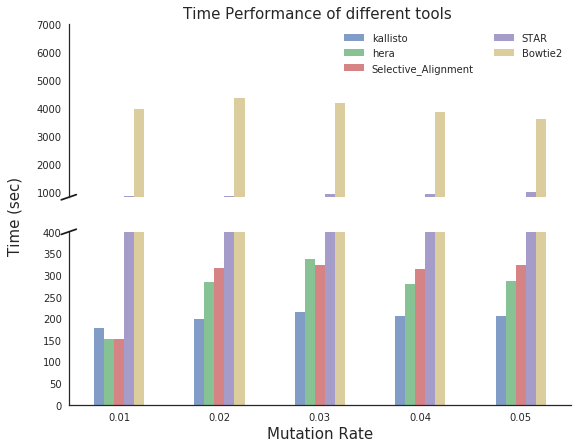

In [335]:
sns.set_style('white')
f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(9,7))
time_df.plot(x="mutation_rate", y=["kallisto", "hera", \
                                          "Selective_Alignment_soft", \
                                          "STAR", "Bowtie2"],\
                         kind="bar",alpha=0.7,ax=ax)

time_df.plot(x="mutation_rate", y=["kallisto", "hera", \
                                          "Selective_Alignment_soft", \
                                          "STAR", "Bowtie2"],\
                         kind="bar",alpha=0.7,ax=ax2, rot=0)

ax.set_ylim(800, 7000)  # outliers only

ax2.set_ylim(0, 400)  # most of the data
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Shrink current axis by 20%
box = ax.get_position()
#ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.tick_params(axis=u'both', which=u'both',length=0)
# Put a legend to the right of the current axis
#ax.legend(loc='best', bbox_to_anchor=(1, 0.5))
ax2.tick_params(axis=u'both', which=u'both',length=0)
ax2.set_xticklabels(np.arange(0.01, 0.06, 0.01))
#ax.set_yticklabels([str(i)+"GB" for i in np.arange(1.0, 2.1, 0.2)])
#ax.set_yticks(ax.get_yticks()[::2])
#ax.set_yticklabels([str(i)+"min" for i in np.arange(15, 116, 25)])
#ax2.set_yticks(ax2.get_yticks()[::2])
#ax2.set_yticklabels([str(i)+"sec" for i in np.arange(0, 500, 100)])
#ax2.yaxis.set_major_locator(plticker.MultipleLocator(1))
#ax.legend_.remove()
ax.legend(["kallisto", "hera","Selective_Alignment","STAR", "Bowtie2"],loc='upper right', ncol=2)
ax2.legend_.remove()


d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
#ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
#ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
#ax.xaxis.tick_top()

# Put a legend to the right of the current axis
#ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Time Performance of different tools ",fontsize=15)
#f.ylabel('Size in disk')
f.text(0.03, 0.5, 'Time (sec)', va='center', rotation='vertical',fontsize=15)
plt.xlabel('Mutation Rate',fontsize=15)

sns.despine()
ax.spines['bottom'].set_visible(False)
plt.savefig('/mnt/scratch7/hirak/bleed_through_7/figs/time_benchmark.pdf', dpi=500)

In [192]:
mem_df

,kallisto,hera,Selective_Alignment_soft,Selective_Alignment_strict,STAR,Bowtie2,mutation_rate
0,4016760.0,6783828.0,6673172.0,6017332.0,8330864.0,13823396.0,1.0
1,9442336.0,6786700.0,6197928.0,6101316.0,8327520.0,12714992.0,2.0
2,9442320.0,6758656.0,6184292.0,6089344.0,8328736.0,10734912.0,3.0
3,9442252.0,6700076.0,6192108.0,6118436.0,8326172.0,8886096.0,4.0
4,9442252.0,6616092.0,6179388.0,6118372.0,8328328.0,8334788.0,5.0


In [326]:
mem_df.div(1024*1024, axis='index')

,kallisto,hera,Selective_Alignment_soft,Selective_Alignment_strict,STAR,Bowtie2,mutation_rate
0,3.830681,6.469563,6.364033,5.738575,7.944931,13.183018,9.536743e-07
1,9.004913,6.472301,5.910805,5.818668,7.941742,12.125961,1.907349e-06
2,9.004898,6.445557,5.897800,5.807251,7.942902,10.237610,2.861023e-06
3,9.004833,6.389690,5.905254,5.834995,7.940456,8.474442,3.814697e-06
4,9.004833,6.309597,5.893124,5.834934,7.942513,7.948673,4.768372e-06


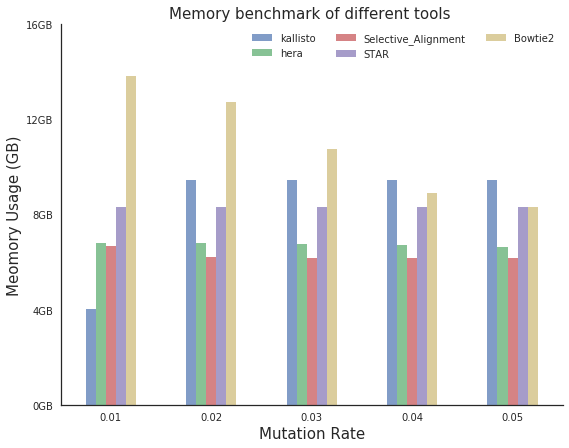

In [337]:
sns.set_style('white')
ax = mem_df.plot(x="mutation_rate", y=["kallisto", "hera", \
                                          "Selective_Alignment_soft", \
                                          "STAR", "Bowtie2"],\
                         kind="bar",alpha=0.7,figsize=(9,7), rot=0)

ax.set_title("Memory benchmark of different tools ",fontsize=15)
ax.set_ylabel("Meomory Usage (GB)",fontsize=15)
ax.legend(["kallisto", "hera","Selective_Alignment","STAR", "Bowtie2"],loc='upper right', ncol=3)

ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels([str(i)+"GB" for i in np.arange(0, 17, 4)])

ax.set_xticklabels(np.arange(0.01, 0.06, 0.01))
#plt.ticklabel_format(style='plain', axis='y')

sns.despine()
plt.xlabel('Mutation Rate',fontsize=15)
plt.savefig('/mnt/scratch7/hirak/bleed_through_7/figs/mem_benchmark.pdf', dpi=500)